<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/1-vae/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Implementation

Adpated From: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

## Set up

In [152]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## Data

In [153]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])

In [154]:
trainset = torchvision.datasets.EuroSAT(root='./data',
                                            download=True, transform=transform)

In [155]:
trainset[0][0].shape

torch.Size([3, 64, 64])

In [156]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True)

In [157]:
print("[LOG] Total number of batches in the dataloader: %d" %len(trainloader))

[LOG] Total number of batches in the dataloader: 1688


### Plot images

In [158]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [159]:
classes = (
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
)

GroundTruth:  River River Highway PermanentCrop River PermanentCrop AnnualCrop Residential River HerbaceousVegetation Pasture River HerbaceousVegetation SeaLake PermanentCrop PermanentCrop


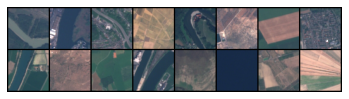

In [160]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

## Model

In [161]:
def create_model():
    #autoencoder = Autoencoder()
    autoencoder = VariationalAutoencoder()
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [162]:
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [163]:
def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

In [164]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [165]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:
!pip install lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
import pytorch_lightning as pl
pl.seed_everything(1234)
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


In [168]:
d = 10

class VariationalAutoencoder(nn.Module):
    def __init__(self,enc_out_dim = 512,latent_dim=10, input_height=64):
        super().__init__()

        # self.encoder = nn.Sequential(
        #     nn.Linear(3*64*64, d ** 2),
        #     nn.ReLU(),
        #     nn.Linear(d ** 2, d * 2)
        # )

        # self.decoder = nn.Sequential(
        #     nn.Linear(d, d ** 2),
        #     nn.ReLU(),
        #     nn.Linear(d ** 2, 3*64*64),
        #     nn.Sigmoid(),
        # )

        self.encoder = resnet18_encoder(False, False)
        
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch):
        x = batch
        x = x.float()

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        return x_encoded,x_hat,elbo


    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         std = logvar.mul(0.5).exp_()
    #         eps = std.data.new(std.size()).normal_()
    #         return eps.mul(std).add_(mu)
    #     else:
    #         return mu

    # def forward(self, y):
    #     #mu_logvar = self.encoder(y.view(-1, 3*64*64)).view(-1, 2, latent_dim)
    #     mu_logvar = self.encoder(y)
    #     mu = mu_logvar[:, 0]
    #     logvar = mu_logvar[:, 1]
    #     z = self.reparameterise(mu, logvar)
    #     return self.decoder(z), mu, logvar

In [169]:
parser = argparse.ArgumentParser(description="Train Autoencoder")
parser.add_argument("--valid", action="store_true", default=False,
                    help="Perform validation only.")

# Create model
autoencoder = create_model()

============== Encoder ==============
ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [170]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in autoencoder.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 17789461.


In [172]:
# Training and testing the VAE

epochs = 10
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        autoencoder.train()
        train_loss = 0
        for y, _ in trainloader:
            y = y.to(device)
            # ===================forward=====================
            loss = autoencoder.training_step(y)[2]
            train_loss += loss.item()
            # ===================backward====================
            autoencoder.configure_optimizers().zero_grad()
            loss.backward()
            autoencoder.configure_optimizers().step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(trainloader):.4f}')

print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(autoencoder.state_dict(), "./weights/autoencoder.pkl")

====> Epoch: 1 Average loss: 8106.0613
====> Epoch: 2 Average loss: 6063.8448
====> Epoch: 3 Average loss: 4033.6095
====> Epoch: 4 Average loss: 2020.6107
====> Epoch: 5 Average loss: 29.8023
====> Epoch: 6 Average loss: -1931.5048
====> Epoch: 7 Average loss: -3858.6771
====> Epoch: 8 Average loss: -5712.2272
====> Epoch: 9 Average loss: -7490.2602
====> Epoch: 10 Average loss: -9133.8279
Finished Training
Saving Model...


GroundTruth:  Residential PermanentCrop Industrial HerbaceousVegetation Highway HerbaceousVegetation Forest Industrial HerbaceousVegetation Forest Forest Residential HerbaceousVegetation PermanentCrop SeaLake HerbaceousVegetation


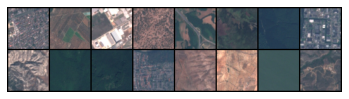

In [173]:
autoencoder.load_state_dict(torch.load("./weights/autoencoder.pkl"))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

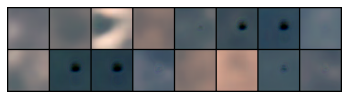

In [174]:
decoded_imgs = autoencoder.training_step(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs))